In [5]:
import os
import pickle
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.spatial import Delaunay
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import networkx as nx
from itertools import combinations
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [6]:
# =====================================================
#                   Utility Functions
# =====================================================

def load_data(filepath: str) -> dict:
    """
    Load data from pickle file. The data is expected to be a dictionary:
    {node_identifier: pd.DataFrame with 'traffic_flow', 'Xkoordinat', 'Ykoordinat'}
    """
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    return data


def split_dataframes(df_dict: dict, train_ratio=0.7, val_ratio=0.1):
    """
    Splits the dictionary of DataFrames into train, validation, and test sets.
    Splits are done by time sequence.

    Args:
        df_dict: {node_key: pd.DataFrame}
        train_ratio: fraction of data for training
        val_ratio: fraction of data for validation

    Returns:
        df_dict_train, df_dict_val, df_dict_test
    """
    df_dict_train, df_dict_val, df_dict_test = {}, {}, {}
    for key, df in df_dict.items():
        n = len(df)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
        df_train = df.iloc[:train_end].copy()
        df_val = df.iloc[train_end:val_end].copy()
        df_test = df.iloc[val_end:].copy()

        df_dict_train[key] = df_train
        df_dict_val[key] = df_val
        df_dict_test[key] = df_test

    return df_dict_train, df_dict_val, df_dict_test


def create_sliding_window_data(df_dict: dict, lookback: int, pred_horizon: int):
    """
    Create sliding windows for each node.
    Returns {node: X_node}, {node: y_node}
    X_node shape: (#samples, lookback), y_node shape: (#samples, pred_horizon)
    """
    X_dict, y_dict = {}, {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node, y_node = [], []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i+lookback])
            y_node.append(node_series[i+lookback:i+lookback+pred_horizon])
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


def combine_node_data(X_dict: dict, y_dict: dict):
    """
    Combine data from all nodes into single arrays.
    """
    X_list = [X_dict[node] for node in X_dict]
    y_list = [y_dict[node] for node in y_dict]
    X_combined = np.concatenate(X_list, axis=0)
    y_combined = np.concatenate(y_list, axis=0)
    return X_combined, y_combined

In [7]:
def clean_graph(graph: nx.Graph) -> nx.Graph:
    """
    Clean the graph: remove self-loops, duplicate edges, keep largest component.
    """
    g = graph.copy()
    g.remove_edges_from(list(nx.selfloop_edges(g)))

    if len(g.nodes) > 0:
        largest_component = max(nx.connected_components(g), key=len)
        g = g.subgraph(largest_component).copy()

    return g
# =====================================================
#                   Graph Construction
# =====================================================

def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a graph where edges are based on spatial proximity.
    """
    graph = nx.Graph()
    coords = {}
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        coords[key] = (x, y)

    # Compute all pairwise distances
    keys = list(df_dict.keys())
    dist_list = []
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            x1, y1 = coords[k1]
            x2, y2 = coords[k2]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            dist_list.append((k1, k2, dist))

    # Sort edges by distance (ascending)
    dist_list.sort(key=lambda x: x[2])

    distances = [dist for _, _, dist in dist_list]
    max_distance = max(distances)
    min_distance = min(distances)

    # Add edges while respecting degree constraints
    for k1, k2, dist in dist_list:
        if graph.degree[k1] < degree and graph.degree[k2] < degree:
            if weighted:
                normalised_distance = (dist - min_distance) / (max_distance - min_distance)
                graph.add_edge(k1, k2, weight=normalised_distance)
            else:
                graph.add_edge(k1, k2)


    graph = clean_graph(graph)
    return graph


def create_delaunay_graph(df_dict):
    """
    Create a graph based on the Delaunay triangulation of spatial coordinates.

    Parameters:
        df_dict (dict): A dictionary where keys are node identifiers and values are
                        pandas DataFrames containing 'Xkoordinat' and 'Ykoordinat'.

    Returns:
        nx.Graph: A Delaunay graph where edges are formed from Delaunay triangulation.
    """
    # Initialize an empty graph
    graph = nx.Graph()

    # Extract node coordinates and their identifiers
    nodes = []
    coords = []
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        nodes.append(key)
        coords.append((x, y))

    # Perform Delaunay triangulation
    tri = Delaunay(coords)

    # Add edges from the Delaunay triangulation
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                node1 = nodes[simplex[i]]
                node2 = nodes[simplex[j]]
                graph.add_edge(node1, node2)

    # Clean the graph (remove self-loops, keep largest connected component, etc.)
    graph = clean_graph(graph)

    return graph

def create_correlation_graph(df_dict_train, df_dict_full, threshold=0.5, weighted=False, degree=6):
    """
    Create a correlation-based graph using training data for correlation calculation.
    """
    graph = nx.Graph()
    keys = list(df_dict_full.keys())
    for key, df in df_dict_full.items():
        graph.add_node(key, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Compute correlation
    corr_matrix = {}
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys[i+1:], i+1):
            corr = np.corrcoef(df_dict_train[k1]['traffic_flow'], df_dict_train[k2]['traffic_flow'])[0, 1]
            corr_matrix[(k1, k2)] = corr
            corr_matrix[(k2, k1)] = corr

    # Sort edges by correlation
    for k1 in keys:
        potential = [(k2, corr_matrix[(k1, k2)]) for k2 in keys if k1 != k2 and (k1, k2) in corr_matrix]
        potential.sort(key=lambda x: -x[1])  # descending order by correlation
        for k2, c in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree and c > threshold:
                if weighted:
                    graph.add_edge(k1, k2, weight=c)
                else:
                    graph.add_edge(k1, k2)
    
    # Find any node without any edges, then connect it to the node with the hgihest correlation
    for k in keys:
        if graph.degree[k] == 0:
            corr = [(k2, corr_matrix[(k, k2)]) for k2 in keys if k != k2 and (k, k2) in corr_matrix]
            corr.sort(key=lambda x: -x[1])
            graph.add_edge(k, corr[0][0], weight=corr[0][1])

    
    # find any nodes that are not connected to any other nodes, and connect
    graph = clean_graph(graph)
    return graph


def create_cosine_graph(df_dict, weighted=False, degree=4, threshold = 0.5):
    """
    Create a graph based on cosine similarity between full node time series.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    features = [df_dict[k]['traffic_flow'].values for k in keys]
    features = np.array(features)  # shape: (#nodes, #timesteps)
    # Compute cosine similarity
    norm = np.linalg.norm(features, axis=1, keepdims=True)
    normed = features / (norm + 1e-8)
    sim_matrix = normed @ normed.T  # cosine similarity

    for i, k1 in enumerate(keys):
        graph.add_node(k1,
                       x=df_dict[k1]['Xkoordinat'].iloc[0],
                       y=df_dict[k1]['Ykoordinat'].iloc[0],
                       traffic_flow=df_dict[k1]['traffic_flow'].values)

    # Sort by similarity
    for i, k1 in enumerate(keys):
        potential = [(keys[j], sim_matrix[i, j]) for j in range(len(keys)) if i != j]
        potential.sort(key=lambda x: -x[1])
        for k2, sim_val in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree and sim_val > 0.5:
                if weighted:
                    graph.add_edge(k1, k2, weight=sim_val)
                else:
                    graph.add_edge(k1, k2)

    # Find any node without any edges, then connect it to the node with the hgihest similarity
    for k in keys:
        if graph.degree[k] == 0:
            sim = [(keys[j], sim_matrix[i, j]) for j in range(len(keys)) if i != j]
            sim.sort(key=lambda x: -x[1])
            graph.add_edge(k, sim[0][0], weight=sim[0][1])
    
    graph = clean_graph(graph)
    return graph


def create_fully_connected_graph(df_dict, weighted=False):
    """
    Create a fully connected graph. Optionally assign random weights.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            if weighted:
                graph.add_edge(k1, k2, weight=np.random.rand())
            else:
                graph.add_edge(k1, k2)
    graph = clean_graph(graph)
    return graph


def create_dynamic_weight_graph(df_dict, lookback, pred_horizon, adaptive_factor=1.0, max_degree=4):
    """
    Create a graph with dynamic weights based on correlation of sliding windows.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Precompute sliding windows
    sliding_windows = {
        k: np.lib.stride_tricks.sliding_window_view(df_dict[k]['traffic_flow'].values, lookback)[:-pred_horizon]
        for k in keys
    }

    # Compute avg correlation over time for each pair
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            w1 = sliding_windows[k1]
            w2 = sliding_windows[k2]
            # correlation per window
            corrs = []
            for t in range(min(len(w1), len(w2))):
                if np.std(w1[t]) > 0 and np.std(w2[t]) > 0:
                    c = np.corrcoef(w1[t], w2[t])[0, 1]
                    corrs.append(c)
            if len(corrs) > 0:
                avg_weight = np.mean(corrs)
                threshold = adaptive_factor * avg_weight
                if avg_weight > threshold:
                    graph.add_edge(k1, k2, weight=avg_weight)

    # Enforce max degree
    for node in list(graph.nodes()):
        edges = sorted(graph.edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)
        if len(edges) > max_degree:
            for edge in edges[max_degree:]:
                graph.remove_edge(edge[0], edge[1])

    graph = clean_graph(graph)
    return graph


def TOTAL_RANDOM_WEIGHTS(df_dict, degrees=32):
    # Initialize a graph
    num_nodes = len(df_dict)
    graph = nx.Graph()

    # Add nodes with attributes
    for i, (key, df) in enumerate(df_dict.items()):
        graph.add_node(i, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0], traffic_flow=df['traffic_flow'].values)

    # Randomly add edges while respecting degree constraints
    nodes = list(graph.nodes)
    max_attempts = num_nodes * degrees * 10  # Safety limit to prevent infinite loops
    attempts = 0

    while any(graph.degree(n) < degrees for n in nodes):
        u, v = np.random.choice(nodes, size=2, replace=False)
        # Add an edge only if it doesn't exist and both nodes are under degree limit
        if not graph.has_edge(u, v) and graph.degree(u) < degrees and graph.degree(v) < degrees:
            graph.add_edge(u, v, weight=np.random.rand())
        
        attempts += 1
        if attempts >= max_attempts:
            print("Warning: Maximum attempts reached, stopping early.")
            break

    # Return the graph and edge weights
    return graph, nx.get_edge_attributes(graph, 'weight')

def connect_nodes_with_erdos_renyi(df_dict, p=0.5, seed=42, weighted=False):
    np.random.seed(seed)
    num_nodes = len(df_dict)

    er_graph = nx.Graph()


    for i, (key, df) in enumerate(df_dict.items()):
        er_graph.add_node(i, 
                          x=df['Xkoordinat'].iloc[0], 
                          y=df['Ykoordinat'].iloc[0], 
                          traffic_flow=df['traffic_flow'].values)

    for u in er_graph.nodes:
        for v in er_graph.nodes:
            if u < v and np.random.rand() < p:
                if weighted:
                    er_graph.add_edge(u, v, weight=np.random.rand())
                else:
                    er_graph.add_edge(u, v)
    # Get edge weights
    edge_weights = nx.get_edge_attributes(er_graph, 'weight')

    return er_graph, edge_weights


def create_adaptive_threshold_graph(df_dict_full, df_dict_train, threshold_factor=0.3, weighted=False, degree=4):
    """
    Create a graph using an adaptive threshold based on the mean and std of correlations.
    """
    graph = nx.Graph()
    correlations = {}

    # Add nodes
    for key, df in df_dict_full.items():
        graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values
        )

    # Compute correlations
    for key1, df1_train in df_dict_train.items():
        for key2, df2_train in df_dict_train.items():
            if key1 >= key2:
                continue
            correlation = np.corrcoef(df1_train['traffic_flow'], df2_train['traffic_flow'])[0, 1]
            correlations[key1, key2] = correlation
            correlations[key2, key1] = correlation

    # Calculate adaptive threshold
    corr_values = np.array(list(correlations.values()))
    adaptive_threshold = np.mean(corr_values) + threshold_factor * np.std(corr_values)

    # Add edges based on adaptive threshold and degree constraint
    for key1 in df_dict_full.keys():
        potential_edges = [
            (key2, correlations[key1, key2])
            for key2 in df_dict_full.keys() if key1 != key2 and (key1, key2) in correlations
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])

        for key2, corr in potential_edges:
            if graph.degree[key1] < degree and graph.degree[key2] < degree:
                if corr > adaptive_threshold:
                    if weighted:
                        graph.add_edge(key1, key2, weight=corr)
                    else:
                        graph.add_edge(key1, key2)
        
    # Find any node without any edges, then connect it to the node with the hgihest correlation
    for k in df_dict_full.keys():
        if graph.degree[k] == 0:
            corr = [(k2, correlations[(k, k2)]) for k2 in df_dict_full.keys() if k != k2 and (k, k2) in correlations]
            corr.sort(key=lambda x: -x[1])
            graph.add_edge(k, corr[0][0], weight=corr[0][1])

    graph = clean_graph(graph)
    return graph 

In [8]:
# =====================================================
#                   Main Execution
# =====================================================

# Hyperparameters
DATA_PATH = "/Users/niklasandersen/Documents/GitHub/P5/data_prep/four_days_days.pkl"  # Adjust your path
TRAIN_RATIO = 0.5
VAL_RATIO = 0.3
LOOKBACK = 50
PRED_HORIZON = 1
HIDDEN_CHANNELS = 64
LR = 1e-3
EPOCHS = 1
DEGREE = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and split data
final_dataframes = load_data(DATA_PATH)
df_dict_train, df_dict_val, df_dict_test = split_dataframes(final_dataframes, TRAIN_RATIO, VAL_RATIO)

# Create sliding window data
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, LOOKBACK, PRED_HORIZON)
X_val_dict, y_val_dict = create_sliding_window_data(df_dict_val, LOOKBACK, PRED_HORIZON)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, LOOKBACK, PRED_HORIZON)

node_lengths = {node: X_train_dict[node].shape[0] for node in X_train_dict}

# Combine data
X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
X_val, y_val = combine_node_data(X_val_dict, y_val_dict)
X_test, y_test = combine_node_data(X_test_dict, y_test_dict)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/niklasandersen/Documents/GitHub/P5/data_prep/four_days_days.pkl'

In [ ]:
graph_models = {
    "Distance_Weighted": lambda: create_distance_graph(final_dataframes, weighted=True, degree=DEGREE),
    "Correlation_Weighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=True, degree=DEGREE),
    "Cosine_Weighted": lambda: create_cosine_graph(df_dict_train, weighted=True, degree=DEGREE),
    "Adaptive_Threshold_Weighted": lambda: create_adaptive_threshold_graph(final_dataframes, df_dict_train, threshold_factor=0.3, weighted=True, degree=DEGREE),
    "Random_Weighted": lambda: connect_nodes_with_erdos_renyi(final_dataframes, p=0.5, weighted=True)[0],
    # Unweighted graphs
    "Distance_Unweighted": lambda: create_distance_graph(final_dataframes, weighted=False, degree=DEGREE),
    "Delaunay_Unweighted": lambda: create_delaunay_graph(final_dataframes),
    "Correlation_Unweighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=False, degree=DEGREE),
    "Adaptive_Threshold_Unweighted": lambda: create_adaptive_threshold_graph(final_dataframes, df_dict_train, threshold_factor=0.3, weighted=False, degree=DEGREE),
    "Cosine_Unweighted": lambda: create_cosine_graph(df_dict_train, weighted=False, degree=DEGREE),
    "Fully_Connected": lambda: create_fully_connected_graph(final_dataframes, weighted=False),
    "Random_Unweighted": lambda: connect_nodes_with_erdos_renyi(final_dataframes, p=0.5)[0],
}

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_3840/3072470495.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


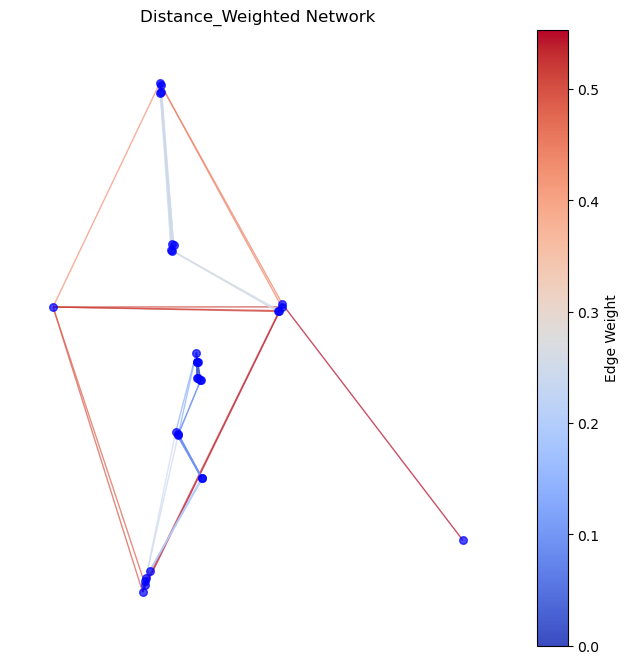

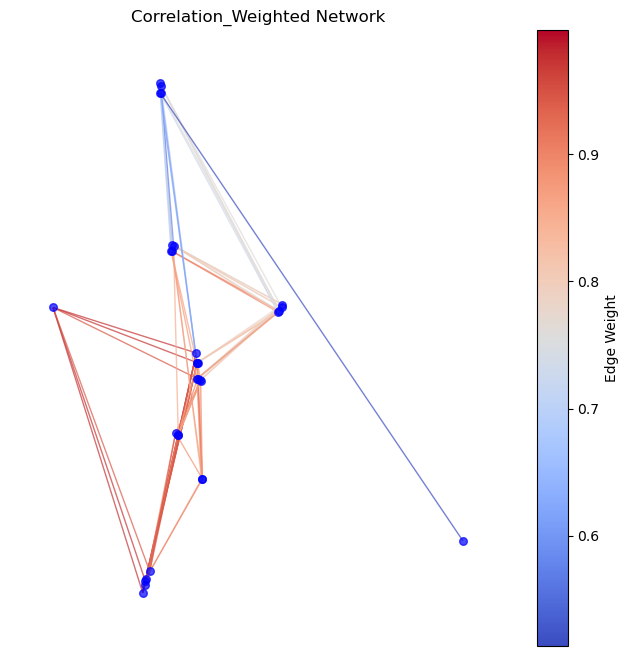

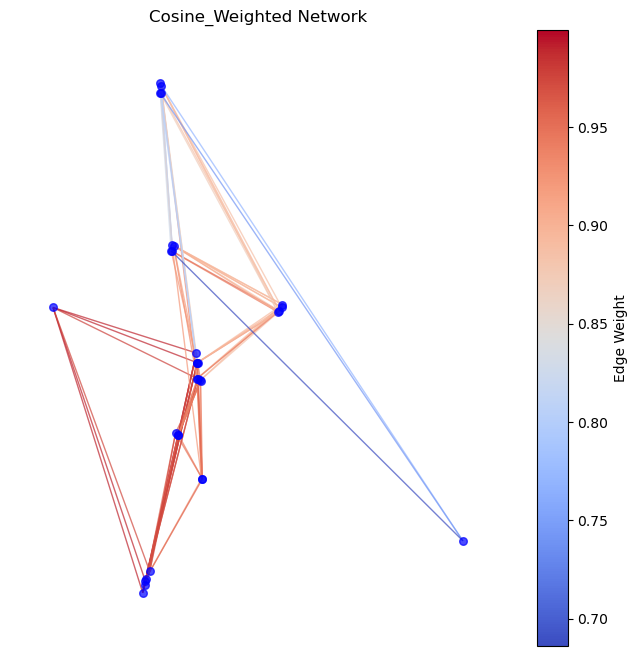

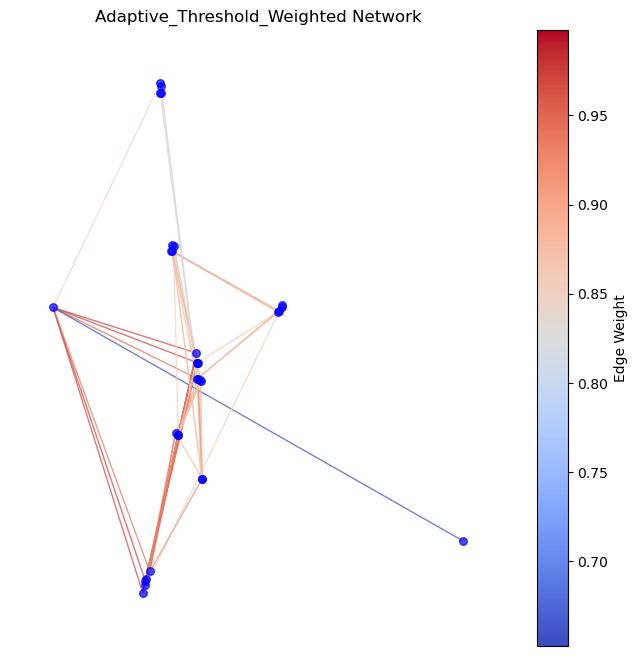

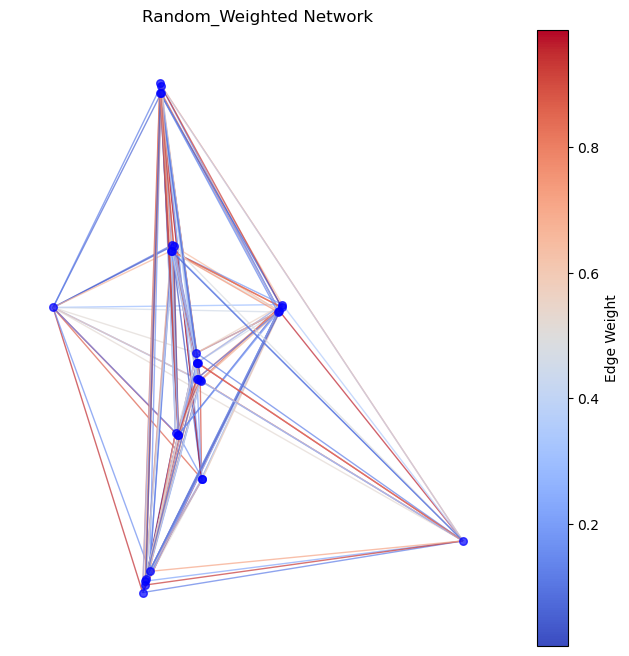

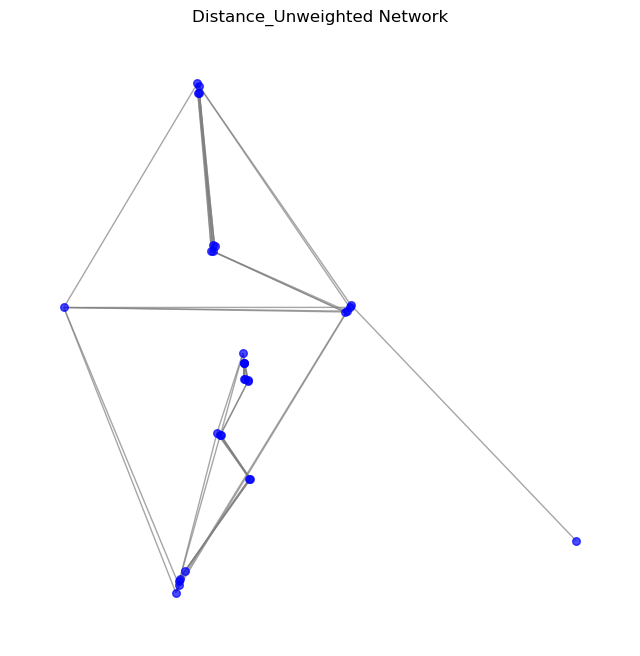

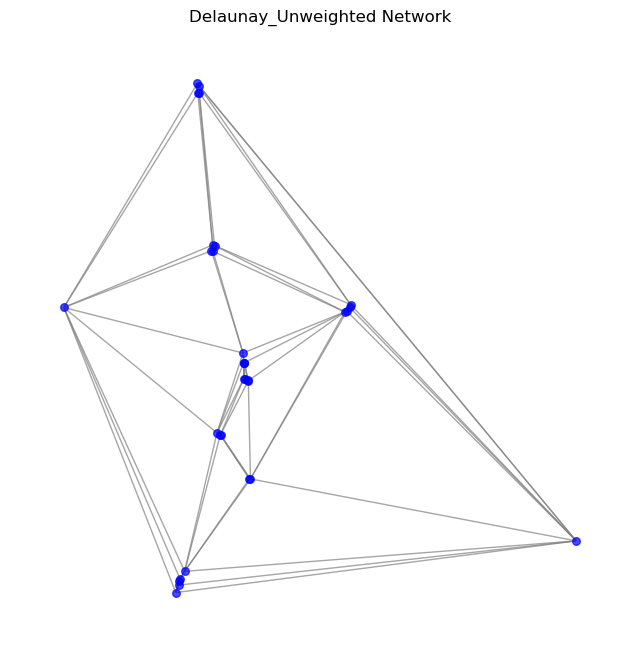

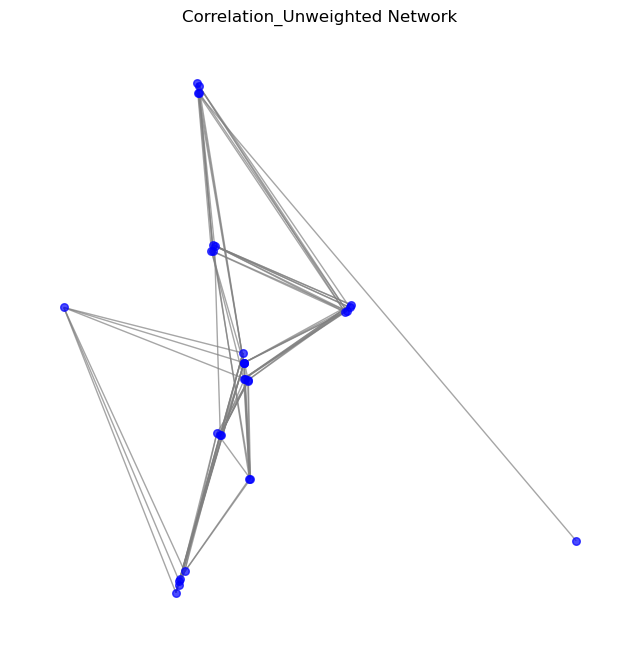

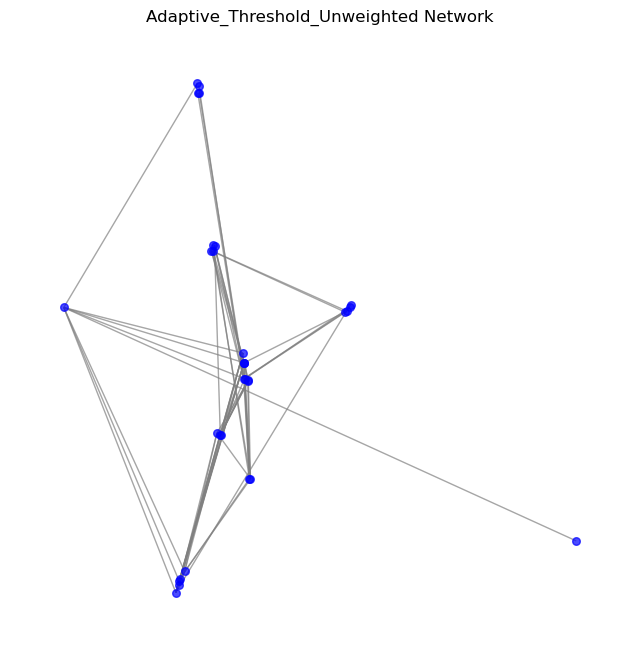

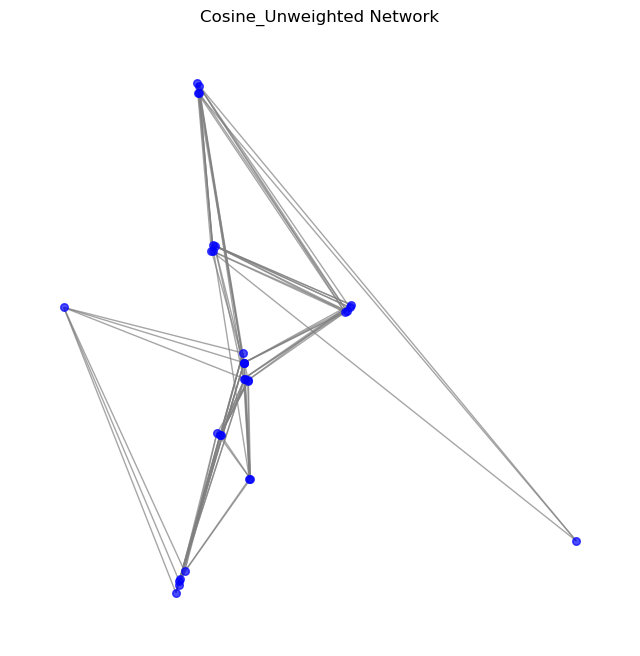

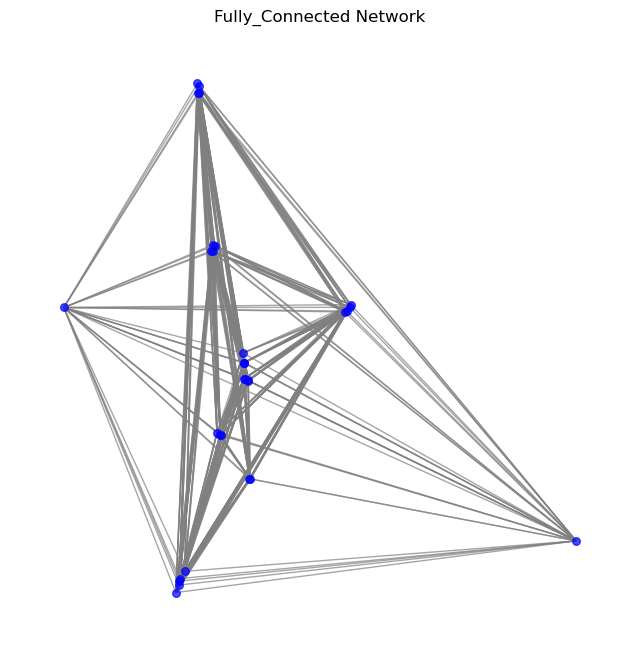

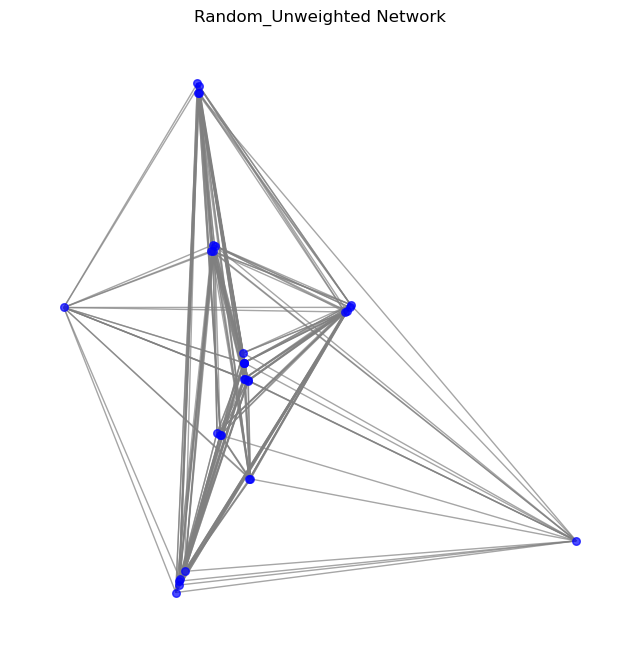

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_graph(graph, title="Graph network", weighted=True):
    """
    Plots a graph with nodes and edges. If weighted, edge colors represent weights.

    Parameters:
        graph (networkx.Graph): The graph to plot.
        title (str): The title of the plot.
        weighted (bool): Whether to use edge weights for coloring.
    """
    # Create a dictionary of node positions
    pos = {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}

    if weighted:
        # Extract edge weights
        edge_weights = nx.get_edge_attributes(graph, 'weight').values()

        # Normalize edge weights for color mapping
        norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
        cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

        # Get edge colors based on the weights
        edge_colors = [cmap(norm(weight)) for weight in edge_weights]

        edge_cmap_args = {
            "edge_color": edge_colors,
            "edge_cmap": cmap,
            "edge_vmin": min(edge_weights),
            "edge_vmax": max(edge_weights),
        }
    else:
        edge_cmap_args = {
            "edge_color": "gray",
        }

    # Plot the graph
    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw(
        graph,
        pos,
        with_labels=False,
        node_size=30,
        node_color="blue",
        alpha=0.7,
        ax=ax,
        **edge_cmap_args
    )

    # Enable axis and set labels
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_title(title)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

    # Add a colorbar for edge weights if weighted
    if weighted:
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax, label='Edge Weight')

    plt.show()

# Example usage for plotting graphs from the dictionary
for model_name, graph_func in graph_models.items():
    graph = graph_func()
    weighted = "Weighted" in model_name  # Determine if the graph is weighted based on its name
    plot_graph(graph, title=f"{model_name} Network", weighted=weighted)
